In [6]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import shap
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config inlinebackend.figure_format = 'svg'
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from category_encoders.target_encoder import TargetEncoder
from implicit import als
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from utils_ import st_scal,min_max
from sklearn.decomposition import PCA
from implicit.bpr import BayesianPersonalizedRanking
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import shap
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items,reduce_mem_usage
from recommenders import MainRecommender

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [8]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [9]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [10]:
recommender = MainRecommender(data_train_lvl_1)

In [11]:
# Изменим гиперпараметры als recommender

recommender.model=recommender.fit(recommender.user_item_matrix,random=50, n_factors=4, regularization=0.03, iterations=20, num_threads=4)

In [12]:
# Метрика качества

def metr(X_train,y_train,train_preds):
    X_res=X_train[['user_id','item_id']]
    X_res['pred']=train_preds[:,1]
    X_res['tag']=y_train
    X_res=X_res.groupby(['user_id','item_id']).mean().reset_index()
    metric=[]
    for user in X_res.user_id.unique():
        m=X_res[X_res.user_id==user].sort_values('pred',ascending = False)[:5].tag.sum()/5
        metric.append(m)
    return np.mean(metric)

In [13]:
# Подготовка данных

def prep_data(data_train_lvl_2,n1=12,n2=15,n3=12):
    users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
    reduce_mem_usage(users_lvl_2)
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    train_users = list(set(data_train_lvl_1['user_id'].unique()) & set(data_val_lvl_1['user_id'].unique()) & set(data_val_lvl_2['user_id'].unique()))
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
 
    # Кандидаты отбираются на основании трех алгоритмов

    users_lvl_2['candidates1'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=n1))
    users_lvl_2['candidates2'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=n2))
    users_lvl_2['candidates3'] = users_lvl_2['user_id'].apply(lambda x: recommender.top_purchases[recommender.top_purchases.user_id==x].item_id[:n3].to_list())
    users_lvl_2['candidates'] = users_lvl_2.candidates1+users_lvl_2.candidates2+users_lvl_2.candidates3
    users_lvl_2=users_lvl_2.drop(['candidates1','candidates2','candidates3'],axis=1)
    
    
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    
    s.name = 'item_id'
   
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['flag'] = 1
    users_lvl_2=users_lvl_2.groupby(['user_id','item_id']).mean().reset_index()

    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 
    
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
   
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)
    
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
    
    targets_lvl_2.age_desc.replace(['45-54','35-44','25-34','65+','55-64','19-24'],[50,40,30,70,60,20],inplace=True)
    targets_lvl_2.age_desc.fillna((targets_lvl_2.age_desc.mean()),inplace=True)
    
    targets_lvl_2.marital_status_code.replace(['U','A','B'],[2,1,0],inplace=True)
    targets_lvl_2.marital_status_code.fillna(10,inplace=True)
    
    
 
    
    return targets_lvl_2



In [14]:
# Новые признаки

def make_feat(X_train):
    
   
    
#     среднee время продажи товара
    
    t=data.groupby(['item_id'])['day','trans_time'].mean()
    X_train=X_train.merge(t, on=['item_id'], how='left')


#     Цена товара
    
    t=data.groupby(['user_id','item_id']).sum()[['sales_value','quantity']]
    t['Price']=t.sales_value/t.quantity+0.01
    X_train=X_train.merge(t, on=['user_id','item_id'], how='left')
    
    
    
#     средняя сумма и количество в чеке юзера
    
    t=data.groupby(['user_id','basket_id']).sum()[['sales_value','quantity']].mean(level='user_id')
    t.columns=['basket_user_sum_mean','basket_user_quant_mean']
    X_train=X_train.merge(t, on='user_id', how='left')
    X_train.sales_value.replace(0,0.01, inplace=True)
    X_train.quantity.replace(0,0.01, inplace=True)
    
#     среднее количество и средняя стоимость товара в чеке
    
    t=data.groupby(['item_id','basket_id']).sum()[['sales_value','quantity']].mean(level='item_id')
    t.columns=['basket_item_sum_mean','basket_item_quant_mean']
    X_train=X_train.merge(t, on='item_id', how='left')
    
#   сумма скидки по данной позиции по юзеру
    
    t=data.groupby(['user_id','item_id']).sum()[['retail_disc','coupon_match_disc']]
    X_train=X_train.merge(t, on=['user_id','item_id'], how='left')
    
#  доля скидки от стоимости товара 

    t=data.groupby(['user_id','item_id']).sum()[['retail_disc','coupon_match_disc','sales_value']]
    t['ratio_retail_disc']=t.retail_disc/(t.sales_value+0.01)
    t['ratio_coupon_match_disc']=t.coupon_match_disc/(t.sales_value+0.01)
    X_train=X_train.merge(t[['ratio_retail_disc','ratio_coupon_match_disc']], on=['user_id','item_id'], how='left')

# средняя сумма/цена по категории в разрезе юзера

    t=X_train.groupby(['user_id','department']).mean()[['sales_value','Price']]
    t.columns=['user_id_department_sum_mean','user_id_department_price_mean']
    X_train=X_train.merge(t, on=['user_id','department'], how='left')

# средняя сумма/цена по бренду в разрезе юзера    

    t=X_train.groupby(['user_id','brand']).mean()[['sales_value','Price']]
    t.columns=['user_id_brand_sum_mean','user_id_brand_price_mean']
    X_train=X_train.merge(t, on=['user_id','brand'], how='left')

# средняя сумма/цена по подкатегории в разрезе юзера 

    t=X_train.groupby(['user_id','sub_commodity_desc']).mean()[['sales_value','Price']]
    t.columns=['user_id_sub_commodity_desc_sum_mean','user_id_sub_commodity_desc_price_mean']
    X_train=X_train.merge(t, on=['user_id','sub_commodity_desc'], how='left')
    
        
# Отношение цены товара к средней стоимости товара в чеке    
    
    X_train['ratio_Price']=X_train['Price']/(X_train['basket_item_sum_mean'])
    


    
# Отношение цены товара к средней цене в категории

    t=X_train.groupby(['department','item_id']).mean()[['Price']]/(X_train.groupby(['department']).mean()[['Price']])
    t.columns=['ratio_department_Price']
    X_train=X_train.merge(t, on=['department','item_id'], how='left') 
    


# Количество покупок товара  за период

    t=data.groupby(['item_id']).count()[['basket_id']]
    t.columns=['count_basket']
    X_train=X_train.merge(t, on=['item_id'], how='left')
    

    
    
    return X_train

In [25]:
# Подготовка данных

X=pd.concat((data_val_lvl_1,data_val_lvl_2), axis=0)
test=pd.read_csv('../course_project/retail_test1.csv')

X_train_prep=prep_data(X)
X_train=make_feat(X_train_prep)
y_train = X_train[['target']]
X_train = X_train.drop(['target'], axis=1)



X_test_prep=prep_data(test)
X_test=make_feat(X_test_prep)
y_test = X_test[['target']]
X_test = X_test.drop(['target'], axis=1)

cat_feat=X_train.select_dtypes(include='object').columns.tolist()
feat_list=X_train.select_dtypes(exclude='object').columns.tolist()
X_train[cat_feat]=X_train[cat_feat].fillna('n')
X_test[cat_feat]=X_test[cat_feat].fillna('n')
X_train[cat_feat]=X_train[cat_feat].astype('category')
X_test[cat_feat]=X_test[cat_feat].astype('category')




Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.00 MB
Decreased by 74.5%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 74.4%


In [ ]:
# В таблице есть пропуски, оставим их обработку алгоритмам

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73365 entries, 0 to 73364
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   user_id                                73365 non-null  int64  
 1   item_id                                73365 non-null  float64
 2   manufacturer                           73365 non-null  int64  
 3   department                             73365 non-null  float64
 4   brand                                  73365 non-null  float64
 5   commodity_desc                         73365 non-null  float64
 6   sub_commodity_desc                     73365 non-null  float64
 7   curr_size_of_product                   73365 non-null  float64
 8   age_desc                               73365 non-null  float64
 9   marital_status_code                    73365 non-null  float64
 10  income_desc                            73365 non-null  float64
 11  ho

In [157]:
pd.set_option('display.max_columns', 500)
X_train.describe()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,day,trans_time,sales_value,quantity,Price,basket_user_sum_mean,basket_user_quant_mean,basket_item_sum_mean,basket_item_quant_mean,retail_disc,coupon_match_disc,ratio_retail_disc,ratio_coupon_match_disc,user_id_department_sum_mean,user_id_department_price_mean,user_id_brand_sum_mean,user_id_brand_price_mean,user_id_sub_commodity_desc_sum_mean,user_id_sub_commodity_desc_price_mean,ratio_Price,ratio_department_Price,count_basket
count,73365.000000,7.336500e+04,73365.000000,73365.000000,73365.000000,7.336500e+04,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,73365.000000,56663.000000,56663.000000,56638.000000,73365.000000,73365.000000,73365.000000,73365.000000,56663.000000,56663.000000,56663.000000,56663.000000,70635.000000,70634.000000,73043.000000,73043.000000,59891.000000,59869.000000,56638.000000,73338.000000,73365.000000
mean,1256.887685,2.506960e+06,1254.556628,0.311363,0.311361,3.113925e-01,0.311538,0.311677,44.718947,6.179350,0.311361,0.311361,0.311361,0.311361,0.311361,362.674306,1564.426930,43.732543,12.827599,3.684203,33.547122,830.871524,4.467892,1.216641,-6.109978,-0.013284,-0.229656,-0.000604,39.916090,3.687201,40.323513,3.693361,42.911082,3.684851,0.878110,1.012494,1574.915341
std,718.579464,3.120392e+06,1535.943596,0.057478,0.049601,1.350873e-01,0.159077,0.145266,8.301223,4.351071,0.107998,0.101065,0.101185,0.101136,0.101294,42.102534,69.743456,90.386967,23.103399,2.322494,19.768881,1259.221248,3.119011,0.288308,17.862599,0.127797,4.976868,0.007221,65.186212,1.541219,54.998970,0.894132,84.314731,2.213967,0.214888,0.547908,3031.910966
min,1.000000,1.178470e+05,2.000000,0.037115,0.284284,1.744492e-09,0.000000,0.000000,20.000000,0.000000,0.222670,0.222670,0.222670,0.222670,0.222670,74.086022,1029.675676,0.010000,0.010000,0.010000,2.480667,1.633333,0.951107,0.952381,-503.360000,-5.600000,-891.000000,-0.267229,0.010000,0.010000,1.500000,1.510000,0.010000,0.010000,0.001519,0.355479,11.000000
25%,647.000000,9.161220e+05,69.000000,0.260221,0.284284,2.312117e-01,0.217016,0.249044,44.718947,1.000000,0.222670,0.222670,0.222670,0.222670,0.222670,348.510833,1539.076063,5.990000,2.000000,2.510000,19.779412,16.562500,2.900942,1.053097,-5.365000,0.000000,-0.250417,0.000000,9.262500,2.936275,10.832273,3.146807,6.570000,2.521250,0.772038,0.734234,97.000000
50%,1263.000000,1.029743e+06,649.000000,0.350729,0.284284,2.858048e-01,0.277238,0.267371,44.718947,10.000000,0.222670,0.222670,0.222670,0.222670,0.222670,361.847826,1562.792593,15.990000,5.000000,3.000000,29.302174,220.347826,3.543053,1.143924,-1.500000,0.000000,-0.090909,0.000000,20.090000,3.308685,21.913793,3.546031,16.816667,3.010000,0.885089,0.873894,300.000000
75%,1879.000000,1.127831e+06,1769.000000,0.350729,0.284284,3.518797e-01,0.376147,0.341176,44.718947,10.000000,0.398258,0.435444,0.425584,0.420383,0.416441,378.836957,1586.203215,44.500000,13.000000,3.957786,43.171485,1198.685950,4.891597,1.300000,0.000000,0.000000,0.000000,0.000000,45.486818,3.946852,47.491111,4.077363,44.462500,3.930667,0.971625,1.066680,1636.000000
max,2500.000000,1.592689e+07,6331.000000,0.404467,0.402220,9.876140e-01,0.987614,0.995391,70.000000,10.000000,0.651769,0.466063,0.473178,0.485677,0.487300,609.688202,1990.057692,2706.420000,272.000000,37.350000,165.159846,10219.527397,61.509545,8.100000,0.000000,0.000000,0.000000,0.000000,2289.300000,35.016667,637.374400,13.379943,2289.300000,37.350000,6.631683,6.104868,27362.000000


In [ ]:
# Распределение целевой переменной примерно 1:2

In [13]:
y_train.value_counts()

target
0.0       50522
1.0       22843
dtype: int64

In [14]:
# Распределение признаков

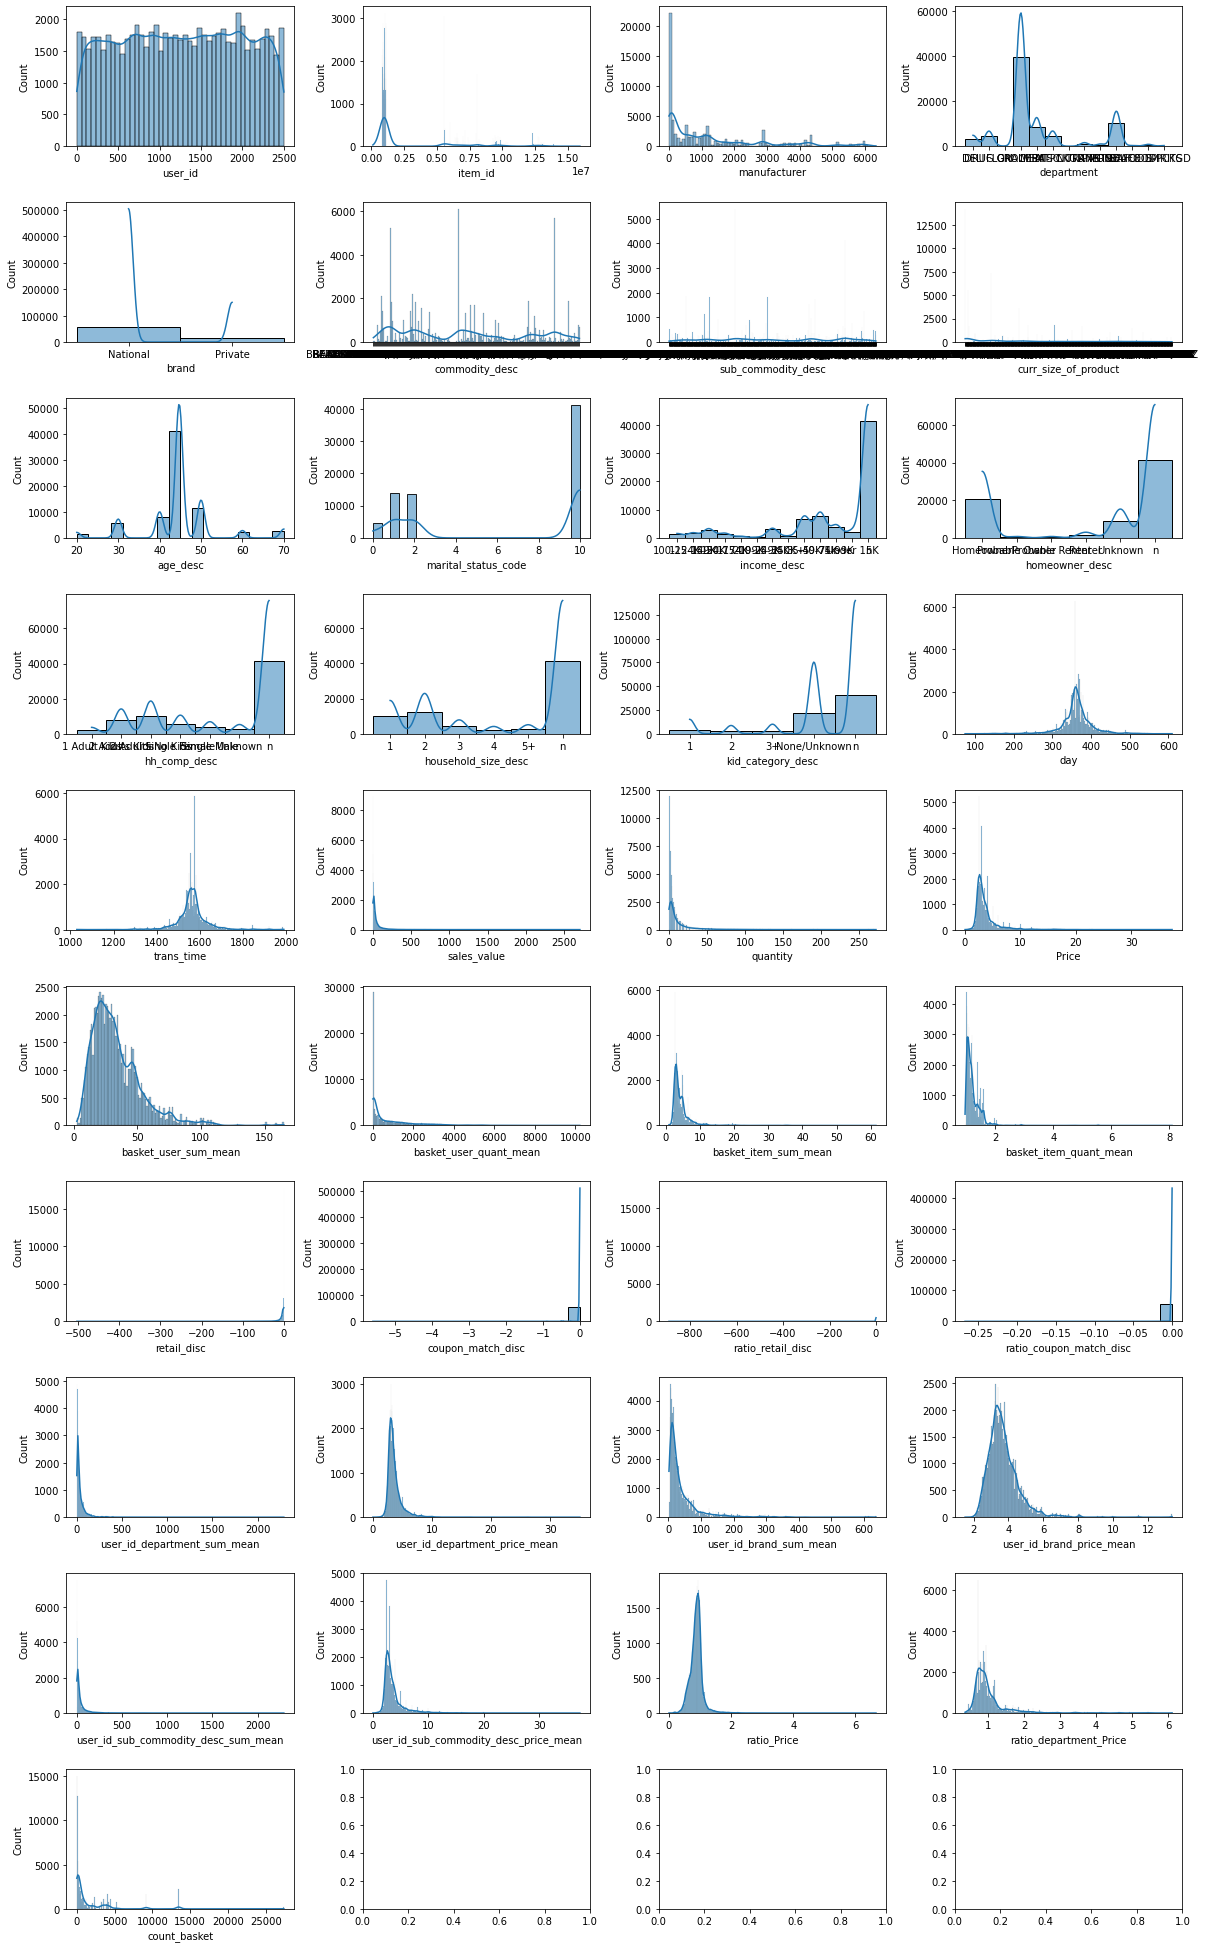

In [16]:
fig, axes = plt.subplots(10, 4, figsize=(20, 35))
ax=axes.flatten()
plt.subplots_adjust(wspace=0.3,hspace=0.4)
i=0
for col in X_train.columns:
    sns.histplot(X_train[col], ax=ax[i],kde=True)
    i+=1 

In [17]:
# Корреляция с таргетом
pd.concat((X_train, y_train),axis=1).corr().target.sort_values(ascending=False)

target                                   1.000000
quantity                                 0.457239
sales_value                              0.381313
user_id_sub_commodity_desc_sum_mean      0.369364
user_id_department_sum_mean              0.333290
user_id_brand_sum_mean                   0.332082
count_basket                             0.198689
basket_user_sum_mean                     0.190439
day                                      0.146761
basket_user_quant_mean                   0.108840
ratio_Price                              0.010390
ratio_retail_disc                        0.009779
ratio_coupon_match_disc                  0.008036
age_desc                                 0.002963
basket_item_quant_mean                   0.002174
user_id                                 -0.005892
trans_time                              -0.010713
item_id                                 -0.032176
user_id_department_price_mean           -0.037510
user_id_sub_commodity_desc_price_mean   -0.061448


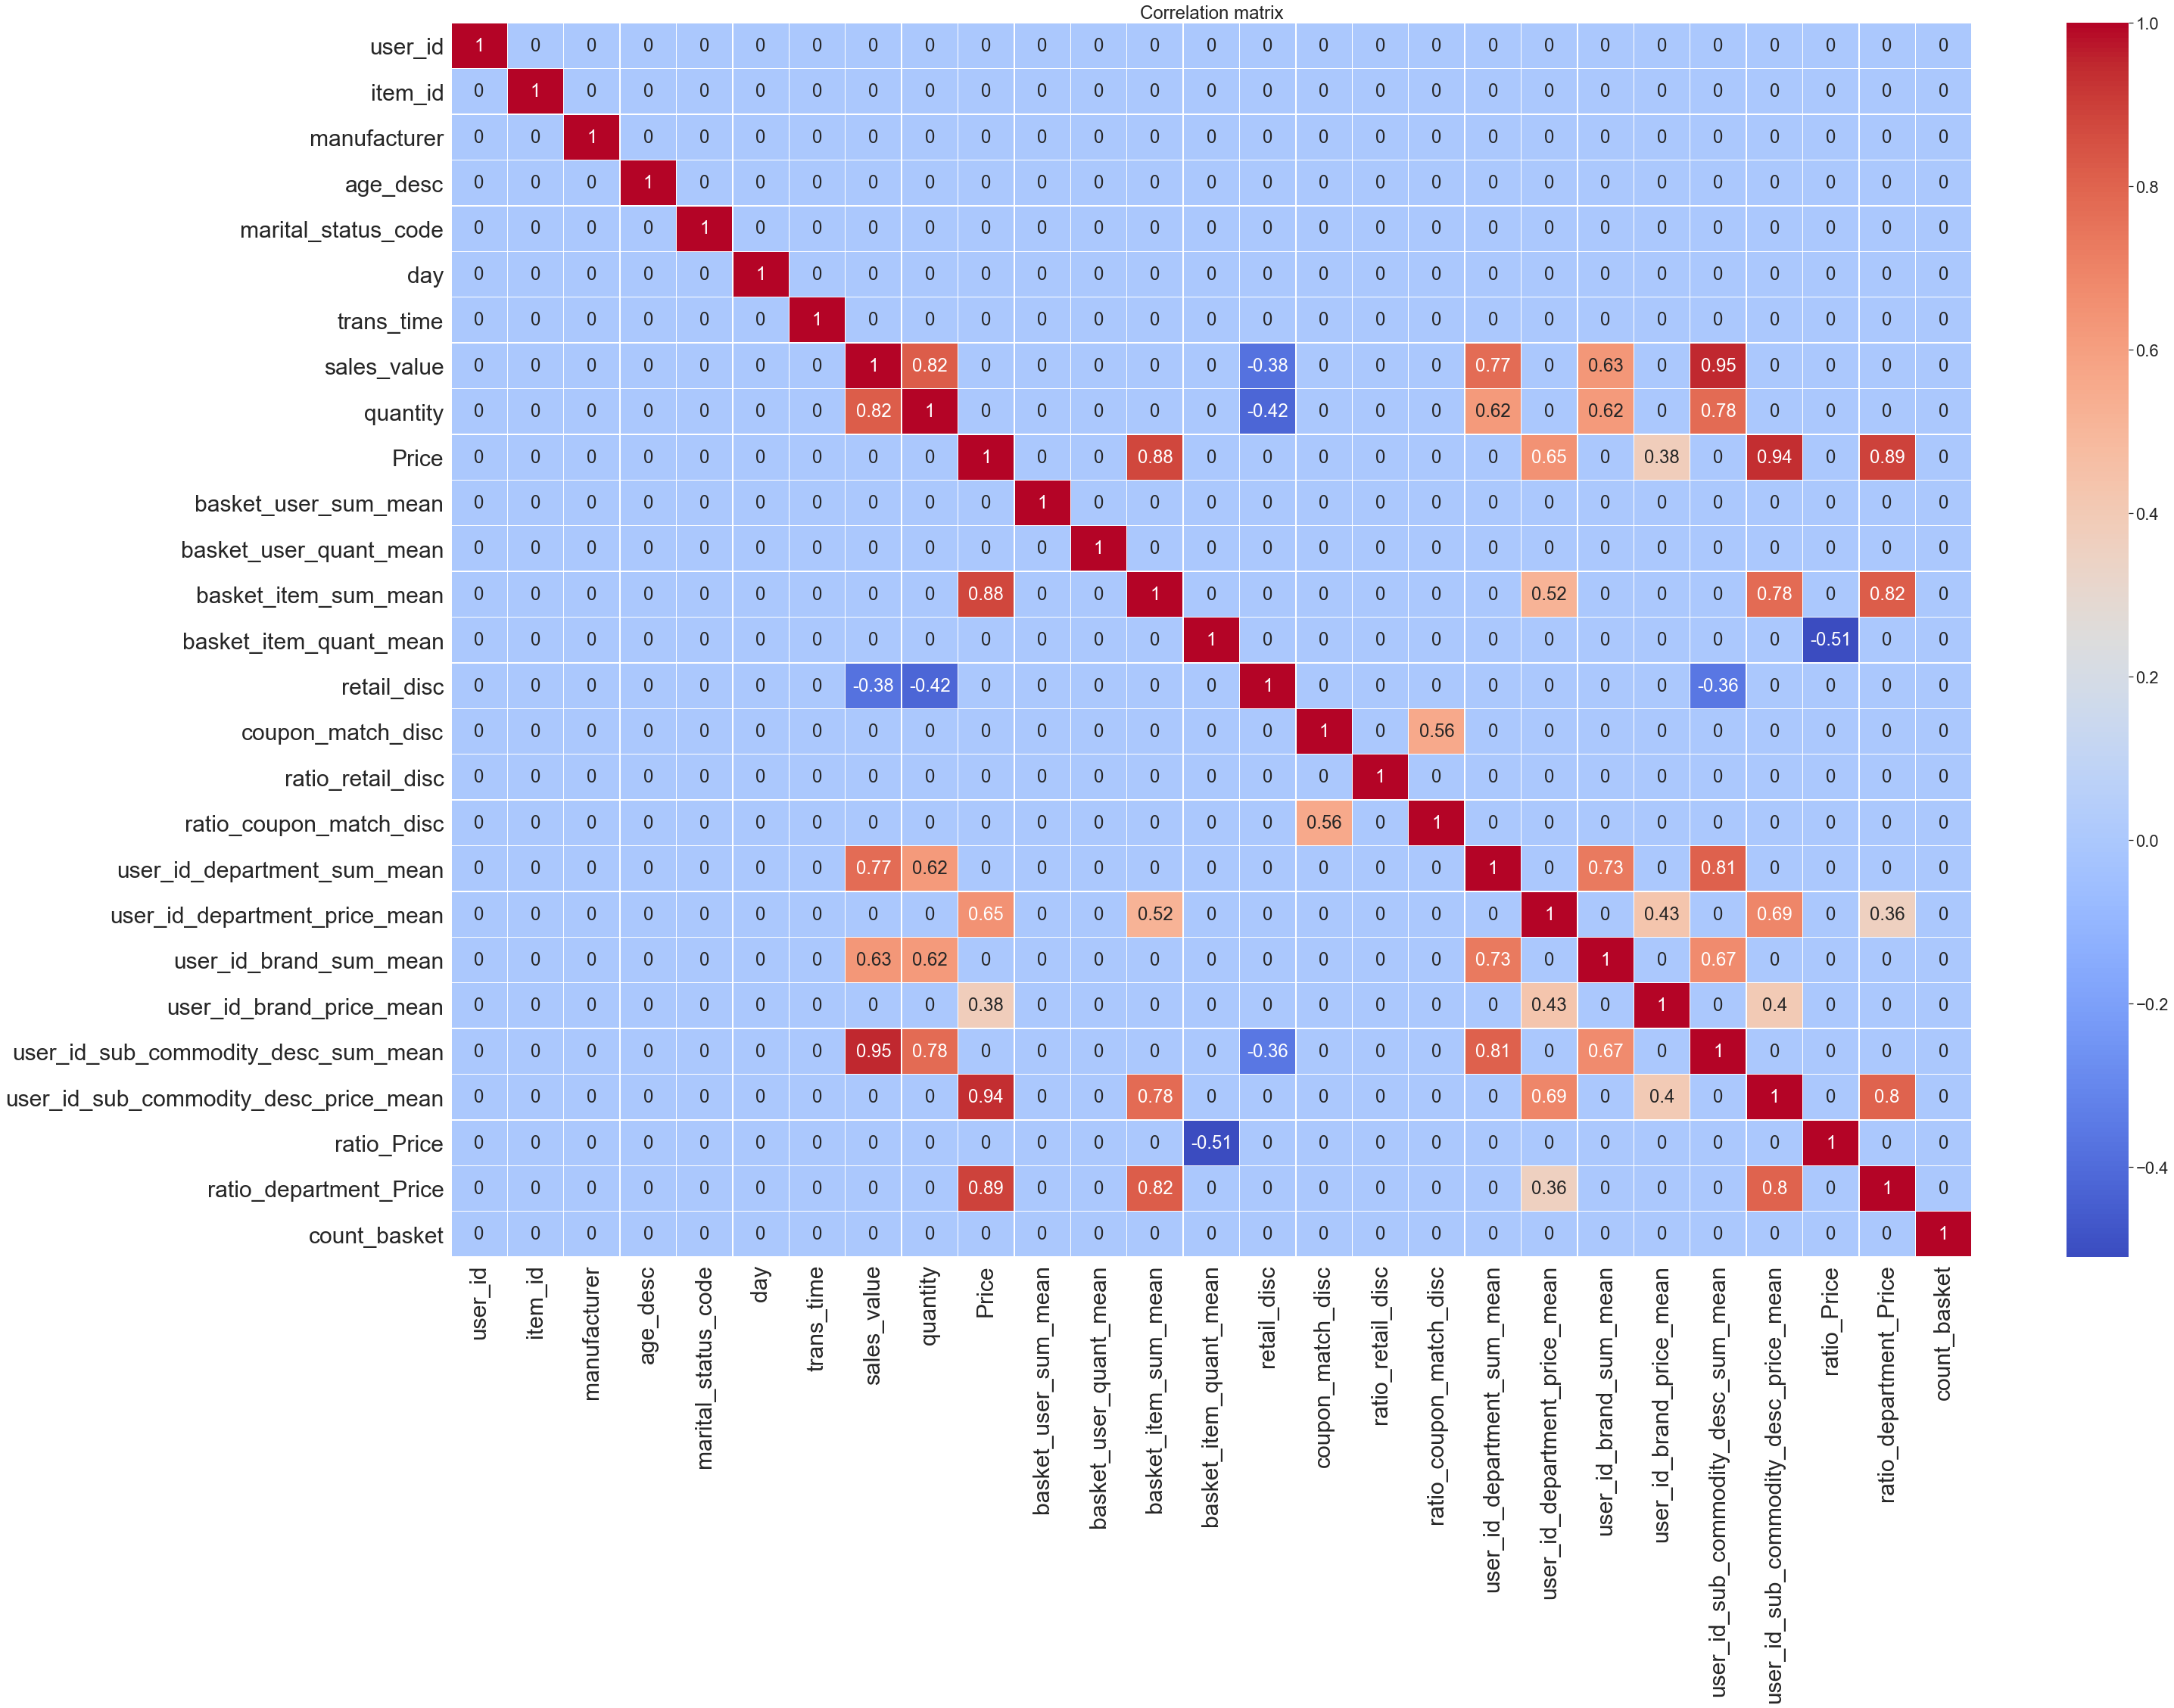

In [19]:
# Корреляция признаков
plt.figure(figsize = (45,30))

sns.set(font_scale=2)
plt.tick_params(axis='y', labelsize=30)
plt.tick_params(axis='x', labelsize=30)

corr_matrix = X_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [128]:
# Гиперпараметры моделей

In [27]:
cb_params = {
        "n_estimators": 1600,
        "learning_rate": 0.03,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "max_bin": 50,
        "verbose": False,
        'one_hot_max_size':20,
        'min_data_in_leaf': 10,
        'scale_pos_weight':0.583333,
        'subsample':0.8,
        'cat_features':cat_feat,
        'grow_policy':'SymmetricTree',
        "max_depth": 10,
        "l2_leaf_reg": 7,
        "early_stopping_rounds": 100,
        "thread_count": 10,
        'random_seed': 8,
    }


In [28]:
lb_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "n_estimators": 2000,
    'reg_lambda':10,
    'max_depth':6,
    'scale_pos_weight':10,
    'colsample_bytree':0.4,
    'subsample_for_bin':500000,
    'num_leaves':80,
    'min_child_samples':15,   
    "seed": 94
}


In [1113]:
# Создадим ансамбль из catboost и lgbm

In [119]:
lgb=LGBMClassifier(**lb_params)
cb = CatBoostClassifier(**cb_params)
vc=VotingClassifier(estimators=[('lgb',lgb),('cb', cb)], voting='soft',weights=[0.4,1])
vc.fit(X_train, y_train)
metr(X_test,y_test,vc.predict_proba(X_test))

0.29164161154539986

In [29]:
lgb=LGBMClassifier(**lb_params)
cb = CatBoostClassifier(**cb_params)
vc=VotingClassifier(estimators=[('lgb',lgb),('cb', cb)], voting='soft',weights=[0.4,1])
vc.fit(X_train, y_train)
metr(X_train, y_train,vc.predict_proba(X_train))

0.7208355091383812

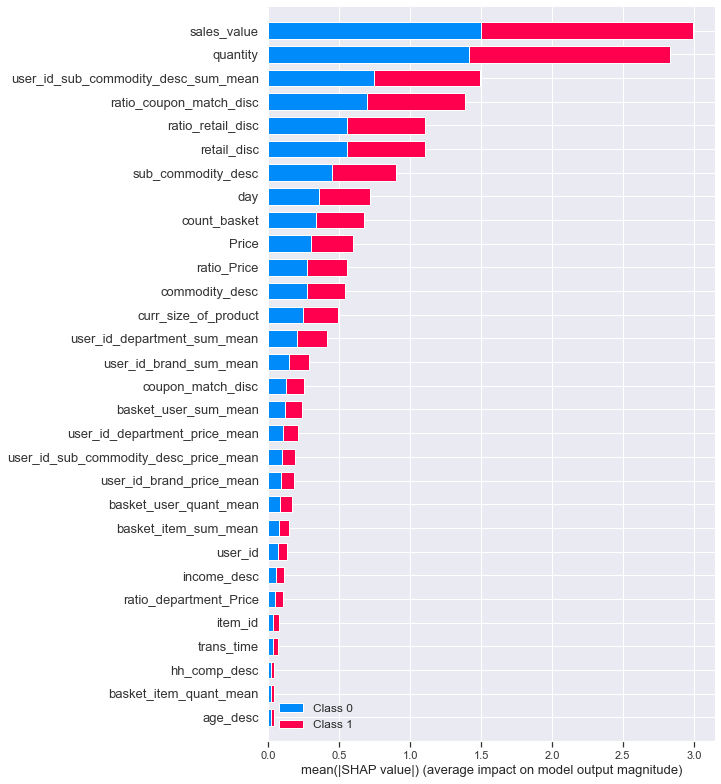

In [30]:
# Важность признаков

lgb.fit(X_train, y_train)
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_test,y_test)
shap.summary_plot(shap_values, X_test,max_display=30 )